In [1]:
pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sktime.forecasting.all import *

/usr/local/lib/python3.7/dist-packages/sktime/utils/validation/_dependencies.py:117: UserWarning: str requires package 'dtw-python' to be present in the python environment, but 'dtw-python' was not found. 'dtw-python' is a soft dependency and not included in the base sktime installation. Please run: `pip install dtw-python` to install the dtw-python package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/sktime/utils/validation/_dependencies.py:117: UserWarning: No module named 'pyod'. 'pyod' is a soft dependency and not included in the base sktime installation. Please run: `pip install pyod` to install the pyod package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/sktime/utils/validation/_dependencies.py:117: UserWarning: No module named 'hmmlearn'. 'hmmlearn.hmm' is a soft dependency and not included in the base sk

#Read Data

In [3]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y)

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
 
y_pred = forecaster.predict(fh)

In [4]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

#Method 2
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

smape(y_test, y_pred)

8.661467699983213

#Apply XGBOOST

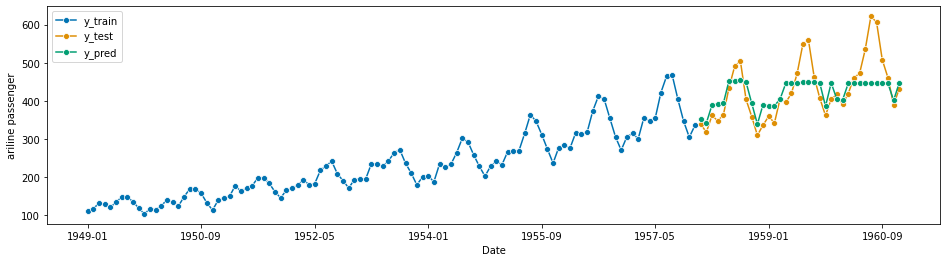

In [5]:
from sktime.forecasting.compose import make_reduction
import xgboost

# Create an exogenous dataframe indicating the month
X = pd.DataFrame({'month': y.index.month}, index=y.index)
X = pd.get_dummies(X.astype(str), drop_first=True)

X_train, X_test = temporal_train_test_split(X, test_size=36)

regressor = xgboost.XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")

# Fit and predict
forecaster.fit(y=y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)

# Evaluate
mean_absolute_percentage_error(y_test, y_pred)
#0.10052889328976747

# Plot predictions with training and test data
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='ariline passenger');


#Time Series Classification

In [6]:
from sktime.classification.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

classifier = TimeSeriesForestClassifier()
classifier.fit(X_train, y_train)
 
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)
#0.8867924528301887

from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, y_pred)
cm


array([[18,  2,  0],
       [ 2, 10,  2],
       [ 2,  0, 17]])

In [7]:
report = classification_report(y_test,y_pred,output_dict=False)
report

'              precision    recall  f1-score   support\n\n           0       0.82      0.90      0.86        20\n           1       0.83      0.71      0.77        14\n           2       0.89      0.89      0.89        19\n\n    accuracy                           0.85        53\n   macro avg       0.85      0.84      0.84        53\nweighted avg       0.85      0.85      0.85        53\n'

#Univariate Time Series Classification

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
#from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.all import *
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope

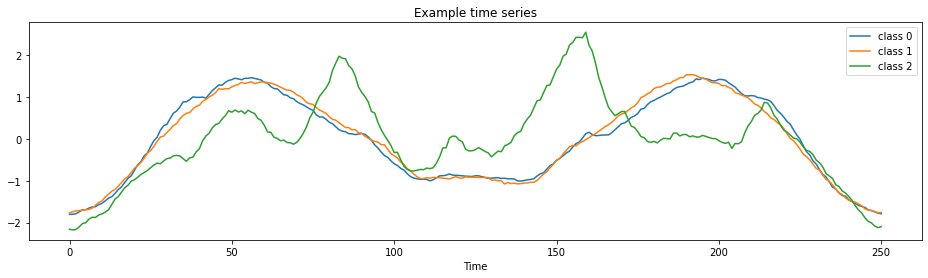

In [44]:
# Data representation
X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#(158, 1) (158,) (53, 1) (53,)
# univariate time series input data
X_train.head()
# binary target variables
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts) 
#['0' '1' '2'] [60 54 44]
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
     X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
     plt.legend()
     ax.set(title="Example time series", xlabel="Time");

#TIME SERIES FOREST


In [45]:
type(X_train)

pandas.core.frame.DataFrame

In [46]:
type(y_train)

numpy.ndarray

In [19]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor


In [20]:
steps = [
     ("extract",RandomIntervalFeatureExtractor(
         n_intervals="sqrt", features=[np.mean, np.std, _slope]
         ),),
     ("clf", DecisionTreeClassifier()),
 ]


In [47]:
#set the pipeline
time_series_tree = Pipeline(steps)

In [56]:
from sktime.datatypes import check_is_scitype
check_is_scitype(y_train, scitype='Series')

True

In [55]:
from sktime.datatypes import check_is_mtype
check_is_mtype(y_train, mtype='pd.Series')

False

In [54]:
from sktime.datatypes._series_as_panel import convert_to_scitype
convert_to_scitype(y_train, to_scitype='Series')

array(['0', '0', '2', '0', '0', '2', '2', '1', '2', '2', '2', '2', '0',
       '1', '0', '0', '1', '1', '2', '0', '1', '1', '0', '0', '0', '1',
       '1', '2', '0', '2', '2', '1', '0', '0', '2', '0', '0', '1', '2',
       '0', '0', '0', '2', '0', '1', '0', '0', '1', '0', '0', '2', '2',
       '0', '0', '2', '0', '2', '1', '0', '0', '0', '0', '2', '0', '0',
       '2', '1', '1', '2', '2', '2', '0', '1', '2', '2', '1', '2', '1',
       '1', '2', '2', '2', '0', '0', '2', '1', '0', '1', '1', '2', '1',
       '1', '0', '1', '1', '2', '1', '1', '1', '2', '0', '1', '0', '2',
       '2', '0', '1', '0', '1', '0', '2', '2', '1', '2', '0', '2', '1',
       '1', '1', '1', '1', '1', '2', '0', '2', '0', '2', '1', '0', '0',
       '1', '1', '2', '2', '0', '1', '0', '1', '0', '2', '1', '1', '2',
       '1', '1', '2', '2', '0', '0', '1', '0', '0', '0', '0', '1', '0',
       '2', '2'], dtype='<U1')

In [ ]:
#from sktime.transformations.base import convert_to
#convert_to(y_train, to_type='np.ndarray')

In [57]:
from sktime.datatypes import SCITYPE_REGISTER
SCITYPE_REGISTER

[('Series', 'uni- or multivariate time series'),
 ('Panel', 'panel of uni- or multivariate time series'),
 ('Hierarchical', 'hierarchical panel of time series with 3 or more levels'),
 ('Alignment', 'series or sequence alignment'),
 ('Table', 'data table with primitive column types'),
 ('Proba',
  'probability distribution or distribution statistics, return types')]

In [58]:
from sktime.datatypes import MTYPE_REGISTER
MTYPE_REGISTER

[('pd.Series', 'Series', 'pd.Series representation of a univariate series'),
 ('pd.DataFrame',
  'Series',
  'pd.DataFrame representation of a uni- or multivariate series'),
 ('np.ndarray',
  'Series',
  '2D numpy.ndarray with rows=samples, cols=variables, index=integers'),
 ('xr.DataArray',
  'Series',
  'xr.DataArray representation of a uni- or multivariate series'),
 ('nested_univ',
  'Panel',
  'pd.DataFrame with one column per variable, pd.Series in cells'),
 ('numpy3D',
  'Panel',
  '3D np.array of format (n_instances, n_columns, n_timepoints)'),
 ('numpyflat',
  'Panel',
  'WARNING: only for internal use, not a fully supported Panel mtype. 2D np.array of format (n_instances, n_columns*n_timepoints)'),
 ('pd-multiindex',
  'Panel',
  'pd.DataFrame with multi-index (instances, timepoints)'),
 ('pd-wide',
  'Panel',
  'pd.DataFrame in wide format, cols = (instance*timepoints)'),
 ('pd-long',
  'Panel',
  'pd.DataFrame in long format, cols = (index, time_index, column)'),
 ('df-list

In [60]:
from sktime.datatypes import check_raise
check_raise(y_train, mtype='np.ndarray')

True

In [61]:
time_series_tree.fit(X_train, y_train)

TypeError: ignored

In [62]:
tsf = TimeSeriesForestClassifier()

In [63]:
tsf = TimeSeriesForestClassifier(
     estimator=time_series_tree, 
     n_estimators=100,
     criterion="entropy",
     bootstrap=True,
     oob_score=True,
     random_state=1,
     n_jobs=-1,
 )
 

TypeError: ignored

AttributeError: ignored

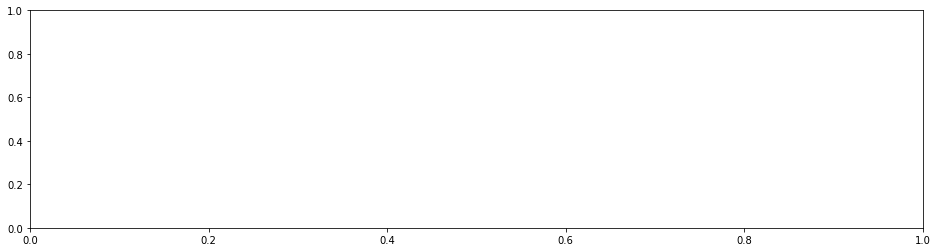

In [64]:
tsf.fit(X_train, y_train)

tsf.score(X_test, y_test)

fi = tsf.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Feature importance");